<a href="https://colab.research.google.com/github/valentinafeve/interpretability/blob/main/notebook_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from PIL import Image
from torchvision.transforms import (Compose, Normalize, Resize, ToPILImage,
                                    ToTensor)
from tqdm.notebook import tqdm, trange
import numpy as np
import logging
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

In [2]:
!mkdir examples

In [3]:
!wget -P examples https://raw.githubusercontent.com/valentinafeve/interpretability/main/examples/bird_32_32.png

--2025-05-29 00:56:34--  https://raw.githubusercontent.com/valentinafeve/interpretability/main/examples/bird_32_32.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1415 (1.4K) [image/png]
Saving to: ‘examples/bird_32_32.png’

bird_32_32.png      100%[===================>]   1.38K  --.-KB/s    in 0s      

2025-05-29 00:56:34 (34.7 MB/s) - ‘examples/bird_32_32.png’ saved [1415/1415]



In [4]:
def plot_tensor(tensor, title=None, save=False):
    tensor = tensor.detach().cpu().numpy()
    vmin, vmax = tensor.min(), tensor.max()
    cmap = 'magma'     # Puedes cambiar a 'magma'

    plt.figure(figsize=(4, 4))
    im = plt.imshow(tensor, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.axis('off')

    if title:
        plt.title(title)

    # Crear colorbar
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.set_ticks([vmin, vmax])

    if save and title:
        plt.savefig(title + '.png', bbox_inches='tight')

    plt.show()
    plt.close()

def plot_tensors(tensor, title=None):
    """"
    Plot a batch of images in a grid. Creates a grid of filters from a tensor.
    The input tensor should be of shape (batch_size, filters, height, width).
    """
    batch, filters, height, width = tensor.shape
    n = np.sqrt(filters).astype(int)
    tensor = tensor.detach().cpu()
    fig, axs = plt.subplots(filters // n, n, figsize=(n + 2.5 , (filters // n) ))

    vmin = tensor.min()
    vmax = tensor.max()
    cmap = 'magma'


    for i in range(filters):
        ax = axs[i // n, i % n]
        ax.imshow(tensor[0, i], cmap)
        ax.axis('off')

    # Agrega colorbar
    cbar_ax = fig.add_axes([0.98, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    norm = Normalize(vmin=vmin, vmax=vmax)
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_ticks([vmin, vmax])


    if title:
        fig.suptitle(title)

    plt.tight_layout()
    plt.show()
    plt.close()

### Instanciación de una capa convolucional con templates

In [5]:
class InterpretableConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, feature_map_size, tau=0.5, beta=4.0, alpha=0.95):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=1, bias=True)
        self.tau = tau
        self.beta = beta
        self.alpha = alpha
        self.n = feature_map_size
        self.templates = self._generate_templates()

    def forward(self, x):
        x = F.relu(self.conv(x))
        if not self.training:
            logging.info("Training mode: applying masks to feature maps.")
            masks = self._assign_masks(x)
            masked_x = x * masks
            return masked_x * (masked_x > 0)
        else:
            logging.info("Inference mode: applying templates to feature maps.")
            return x

    def _generate_templates(self):
        templates = []
        for i in range(self.n):
            for j in range(self.n):
                t = torch.full((self.n, self.n), -self.tau)
                for x in range(self.n):
                    for y in range(self.n):
                        dist = abs(x - i) + abs(y - j)
                        t[x, y] = self.tau * max(1 - self.beta * dist / self.n, 0)
                templates.append(t)
        return torch.stack(templates)

    def _assign_masks(self, x):

        B, C, H, W = x.shape

        x_flat = x.view(B * C, H, W)
        masks = []

        for fmap in x_flat:
            mu_hat = torch.argmax(fmap.view(-1))
            i, j = mu_hat // self.n, mu_hat % self.n
            idx = i * self.n + j
            mask = self.templates[idx]
            masks.append(mask)

        masks = torch.stack(masks).view(B, C, H, W).to(x.device)
        return masks

In [6]:
filters = 3
interpretable_cnn = InterpretableConvLayer(3, filters, 3, 32, tau=4.00, beta=2.00, alpha=1.95)
interpretable_cnn.templates

tensor([[[4.0000, 3.7500, 3.5000,  ..., 0.0000, 0.0000, 0.0000],
         [3.7500, 3.5000, 3.2500,  ..., 0.0000, 0.0000, 0.0000],
         [3.5000, 3.2500, 3.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[3.7500, 4.0000, 3.7500,  ..., 0.0000, 0.0000, 0.0000],
         [3.5000, 3.7500, 3.5000,  ..., 0.0000, 0.0000, 0.0000],
         [3.2500, 3.5000, 3.2500,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[3.5000, 3.7500, 4.0000,  ..., 0.0000, 0.0000, 0.0000],
         [3.2500, 3.5000, 3.7500,  ..., 0.0000, 0.0000, 0.0000],
         [3.0000, 3.2500, 3.5000,  ..., 0.0000, 0.0000, 0.

### Gráfico de los templates en la capa convolucional interpretable

<ipython-input-4-842544e63268>:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


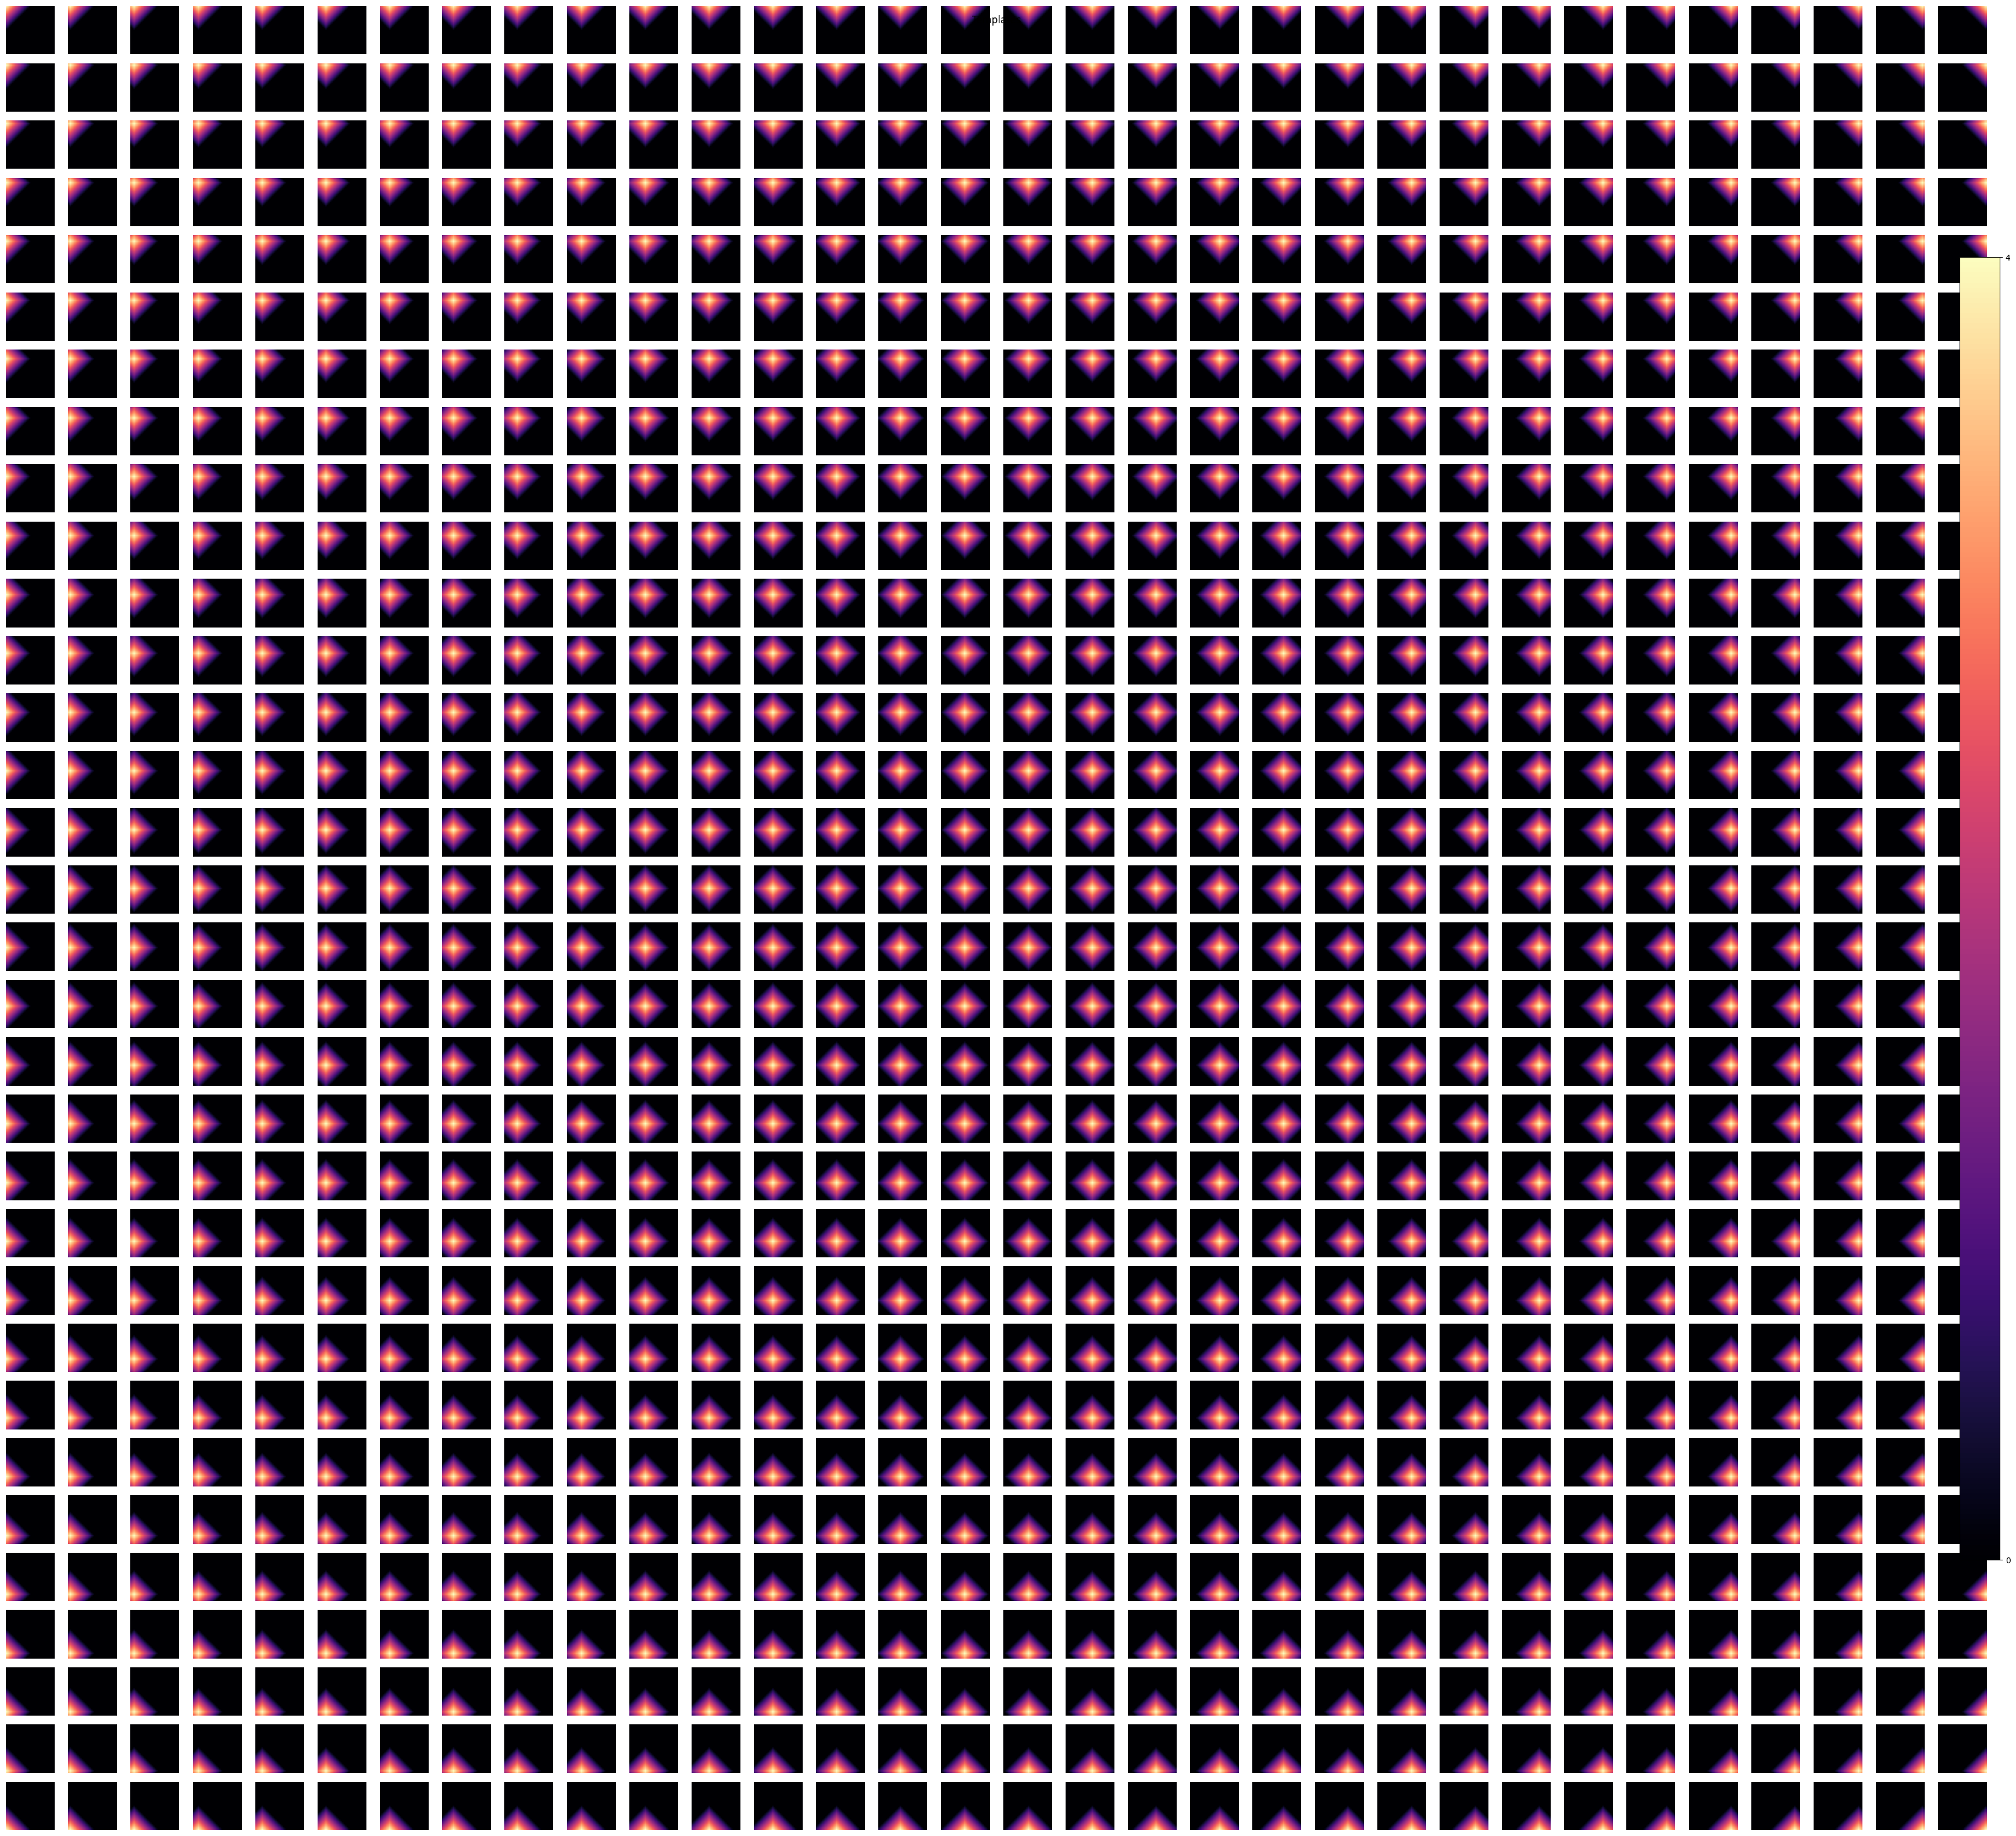

In [7]:
plot_tensors(interpretable_cnn.templates.unsqueeze(0), title='Templates')

In [8]:
#### Ejemplo de uso con una imagen de 32 x 32

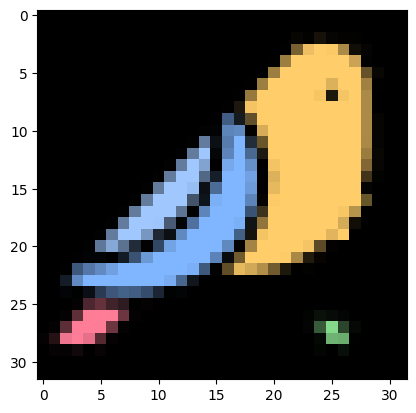

In [9]:
image = Image.open("examples/bird_32_32.png")
image_as_tensor = ToTensor()(image).unsqueeze(0)[:, :3, :, :]
plt.imshow(ToPILImage()(image_as_tensor[0]))

In [10]:
interpretable_cnn = interpretable_cnn.train()
output = interpretable_cnn(image_as_tensor)
output.shape

torch.Size([1, 3, 32, 32])

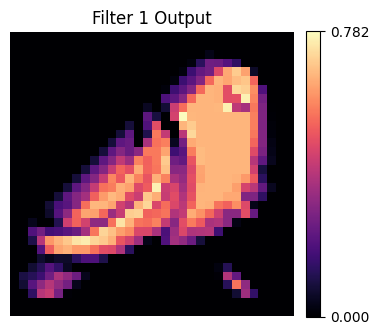

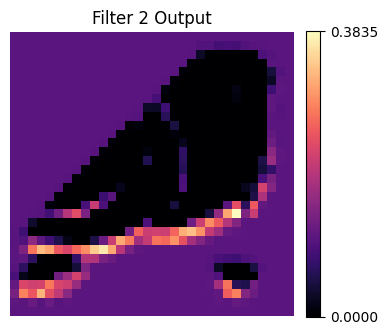

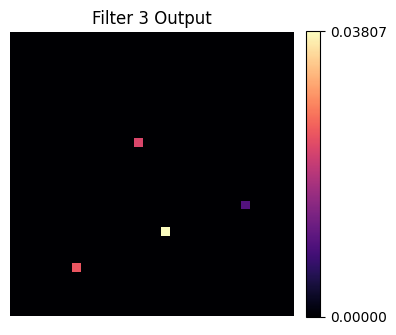

In [11]:
for i in range(filters):
    image = output[0, i, :, :]
    plot_tensor(image, title=f"Filter {i+1} Output")

In [12]:
interpretable_cnn = interpretable_cnn.eval()
output = interpretable_cnn(image_as_tensor)
output.shape

torch.Size([1, 3, 32, 32])

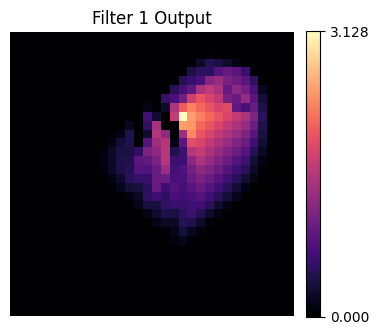

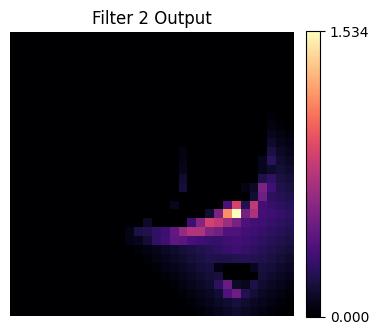

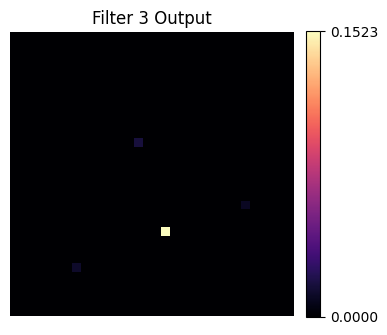

In [13]:
for i in range(filters):
    image = output[0, i, :, :]
    plot_tensor(image, title=f"Filter {i+1} Output")

In [14]:
interpretable_cnn.templates

tensor([[[4.0000, 3.7500, 3.5000,  ..., 0.0000, 0.0000, 0.0000],
         [3.7500, 3.5000, 3.2500,  ..., 0.0000, 0.0000, 0.0000],
         [3.5000, 3.2500, 3.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[3.7500, 4.0000, 3.7500,  ..., 0.0000, 0.0000, 0.0000],
         [3.5000, 3.7500, 3.5000,  ..., 0.0000, 0.0000, 0.0000],
         [3.2500, 3.5000, 3.2500,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[3.5000, 3.7500, 4.0000,  ..., 0.0000, 0.0000, 0.0000],
         [3.2500, 3.5000, 3.7500,  ..., 0.0000, 0.0000, 0.0000],
         [3.0000, 3.2500, 3.5000,  ..., 0.0000, 0.0000, 0.

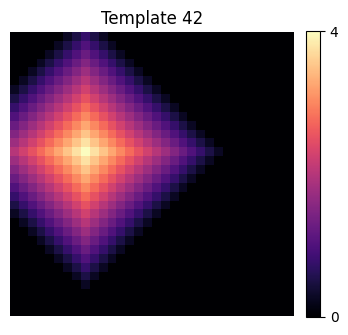

In [15]:
plot_tensor(interpretable_cnn.templates[424], title="Template 42")

In [16]:
output.shape

torch.Size([1, 3, 32, 32])

In [101]:
def MI(X, templates):
    filters = X.shape[1]
    n_templates = templates.shape[1]
    n = templates.shape[-1]
    X_ = X.unsqueeze(1)
    templates_ = templates.unsqueeze(2)
    p_x = ((X_ > 0).sum(dim=(3, 4)) / (n*n)).unsqueeze(-1).unsqueeze(-1)
    print(p_x.shape)

    p_T = ((templates_ > 0).sum(dim=(3, 4))  / (n*n)).unsqueeze(-1).unsqueeze(-1)

    print(p_T)
    p_x_T = (X_.matmul(templates_) / (p_x * p_T)).nan_to_num(nan=0.0, posinf=0.0, neginf=0.0)
    print(p_x_T)
    p_x_expanded = p_x.unsqueeze(-1).unsqueeze(-1)
    MI = - (p_x_T) * torch.log2((p_x_T + 1e-10) ) / ((p_x * p_T) + 1e-10)
    return MI.sum(dim=(1, 2, 3, 4)) / (n*n*n_templates*filters)

In [102]:
interpretable_cnn = interpretable_cnn.train()
output = interpretable_cnn(image_as_tensor)
a = output
b = interpretable_cnn.templates.unsqueeze(0).repeat(9, 1, 1, 1)
x = MI(a, b)
x

torch.Size([1, 1, 3, 1, 1])
tensor([[[[[0.1328]]],


         [[[0.1475]]],


         [[[0.1611]]],


         ...,


         [[[0.1611]]],


         [[[0.1475]]],


         [[[0.1328]]]],



        [[[[0.1328]]],


         [[[0.1475]]],


         [[[0.1611]]],


         ...,


         [[[0.1611]]],


         [[[0.1475]]],


         [[[0.1328]]]],



        [[[[0.1328]]],


         [[[0.1475]]],


         [[[0.1611]]],


         ...,


         [[[0.1611]]],


         [[[0.1475]]],


         [[[0.1328]]]],



        ...,



        [[[[0.1328]]],


         [[[0.1475]]],


         [[[0.1611]]],


         ...,


         [[[0.1611]]],


         [[[0.1475]]],


         [[[0.1328]]]],



        [[[[0.1328]]],


         [[[0.1475]]],


         [[[0.1611]]],


         ...,


         [[[0.1611]]],


         [[[0.1475]]],


         [[[0.1328]]]],



        [[[[0.1328]]],


         [[[0.1475]]],


         [[[0.1611]]],


         ...,


         [[[0.1611]]],




tensor([-2051.4336, -2051.4336, -2051.4336, -2051.4336, -2051.4336, -2051.4336,
        -2051.4336, -2051.4336, -2051.4336], grad_fn=<DivBackward0>)

In [19]:
interpretable_cnn = interpretable_cnn.eval()
output = interpretable_cnn(image_as_tensor)
a = output.repeat(9, 1, 1, 1)
b = interpretable_cnn.templates.unsqueeze(0).repeat(9, 1, 1, 1)
print(a.shape)
print(b.shape)
x = MI(a, b)
x

torch.Size([9, 3, 32, 32])
torch.Size([9, 1024, 32, 32])


tensor([-17.8030, -17.8030, -17.8030, -17.8030, -17.8030, -17.8030, -17.8030,
        -17.8030, -17.8030], grad_fn=<DivBackward0>)

In [67]:
class Model(nn.Module):
    def __init__(self, feature_map_size):
        super().__init__()
        self.cnn = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.icnn = InterpretableConvLayer(in_channels=16, out_channels=6, kernel_size=3, feature_map_size=16)
        self.classifier = nn.Linear(384 , 10)

    def forward(self, x):
        x = self.cnn(x)
        x = self.pool(x)
        x = nn.ReLU()(x)
        x = self.icnn(x)
        x = nn.ReLU()(x)
        icnn_output = x
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        x = torch.softmax(x, dim=1)
        return x, icnn_output


In [21]:
torch.softmax(torch.tensor([0.1, 0.2, 0.3]), dim=0)

tensor([0.3006, 0.3322, 0.3672])

In [74]:
transformations = Compose([
    Resize((32, 32)),
    ToTensor()
])

In [75]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transformations)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transformations)

In [76]:
mnist_trainset[0][1]

5

In [25]:
def one_hot_encode(y, n_classes=10):
    y_one_hot = torch.zeros((n_classes))
    y_one_hot[y] = 1
    return y_one_hot

In [26]:
one_hot_encode(mnist_trainset[0][1])

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [27]:
# Transform target to one-hot encoding
mnist_trainset.target_transform = lambda x: one_hot_encode(x, n_classes=10)
mnist_testset.target_transform = lambda x: one_hot_encode(x, n_classes=10)


In [29]:
BATCH_SIZE = 256
train_dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(mnist_testset, batch_size=BATCH_SIZE, shuffle=False)

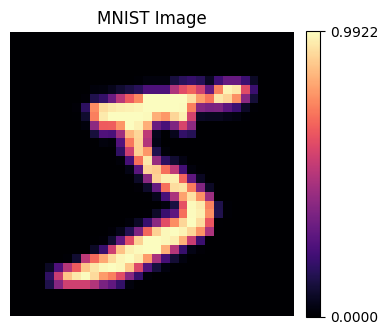

In [37]:
plot_tensor(mnist_trainset[0][0].permute(1, 2, 0), title="MNIST Image")

In [ ]:
model = Model(feature_map_size=32)

In [38]:
x, icnn_output = model(mnist_trainset[0][0].unsqueeze(0))
icnn_output.shape

torch.Size([1, 6, 16, 16])

In [39]:
model.icnn.templates.unsqueeze(0).shape

torch.Size([1, 256, 16, 16])

In [40]:
icnn_output.max()

tensor(0.5008, grad_fn=<MaxBackward1>)

In [68]:
model = Model(feature_map_size=32)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [73]:
lambda_ = 1e-2
EPOCHS = 10

losses = {
    "total_loss": [],
    "class_loss": [],
    "interp_loss": []
}
model.train()
for epoch in trange(EPOCHS):
    for images, labels in tqdm(train_dataloader, desc="Training", leave=False):
        y_pred, icnn_output = model(images)

        class_loss = criterion(y_pred.squeeze(1), labels.float())

        batch_size = images.shape[0]
        templates = model.icnn.templates.unsqueeze(0).repeat(batch_size, 1, 1, 1)
        interp_loss = MI(icnn_output, templates).sum()
        total_loss = lambda_ * interp_loss + (1 - lambda_) * class_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()


    losses["total_loss"].append(total_loss.item())
    losses["class_loss"].append(class_loss.item())
    losses["interp_loss"].append(interp_loss.item())
    print(f"Epoch {epoch+1}/{EPOCHS}, Total Loss: {total_loss.item():.4f}, Class Loss: {class_loss.item():.4f}, Interp Loss: {interp_loss.item():.4f}")



  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

KeyboardInterrupt: 

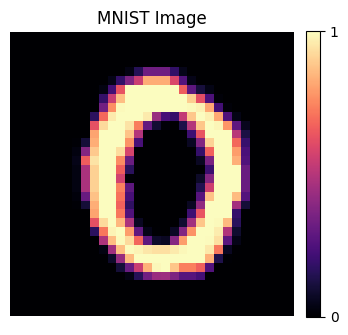

In [46]:
import random
random_i = random.randint(0, len(mnist_testset))
rand_item = mnist_testset[random_i]
plot_tensor(rand_item[0].permute(1, 2, 0), title="MNIST Image")

In [ ]:
y, icnn_output = model(rand_item[0].unsqueeze(0))
y

In [ ]:
icnn_output.shape

In [ ]:
plot_tensors(icnn_output, title=None)

In [58]:
MI(rand_item[0].unsqueeze(0), model.icnn.templates.unsqueeze(0))

RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [256, 32] but got: [256, 16].

In [63]:
rand_item[0].unsqueeze(0).shape

torch.Size([1, 1, 32, 32])

In [64]:
model.icnn.templates.shape

torch.Size([1024, 32, 32])